# **Visual Analytics Final Project**
## **A Visual Music Recommender System Powered by Spotify Data**
---
### Members:
- Marina Castellano Blanco NIA 242409
- Júlia Othats-Dalès Gibert NIA 254435


## **1. Libraries**

This section imports all necessary **Python libraries** for data manipulation, visualization, etc. We also set a default visual style for plots.

In [54]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter
import numpy as np

In [55]:
sns.set(style="whitegrid")

## **2. Loading and Merging**

This section handles the **loading of three main datasets** (Track/Artist data, Artist Metadata, and Audio Features) from CSV files. It includes initial **data cleaning** steps, such as:
1.  Converting track durations to **seconds**.
2.  **Concatenating** fragmented datasets.
3.  Cleaning **artist names** to isolate the main artist for accurate **merging** with artist metadata (e.g., country of origin).
4.  Standardizing column names across datasets.

### 2.1. Dataset Spotify Tracks and Artists

In [56]:
data1 = pd.read_csv('data/track_artists/spotify_data1.csv')
data2 = pd.read_csv('data/track_artists/spotify_data2.csv')

# Convertir duración a segundos
if 'track_duration_min' in data1.columns:
    data1['track_duration_sec'] = (data1['track_duration_min'] * 60).round().astype(int)
    data1.drop(columns=['track_duration_min'], inplace=True)

if 'track_duration_ms' in data2.columns:
    data2['track_duration_sec'] = (data2['track_duration_ms'] / 1000).round().astype(int)
    data2.drop(columns=['track_duration_ms'], inplace=True)

# Concatenar datasets
df_spotify = pd.concat([data1, data2], axis=0).reset_index(drop=True)

df_spotify.head()

,track_id,track_name,track_number,track_popularity,explicit,artist_name,artist_popularity,artist_followers,artist_genres,album_id,album_name,album_release_date,album_total_tracks,album_type,track_duration_sec
0,3EJS5LyekDim1Tf5rBFmZl,Trippy Mane (ft. Project Pat),4,0,True,Diplo,77.0,2812821.0,moombahton,5QRFnGnBeMGePBKF2xTz5z,"d00mscrvll, Vol. 1",2025-10-31,9,album,93
1,1oQW6G2ZiwMuHqlPpP27DB,OMG!,1,0,True,Yelawolf,64.0,2363438.0,"country hip hop, southern hip hop",4SUmmwnv0xTjRcLdjczGg2,OMG!,2025-10-31,1,single,184
2,7mdkjzoIYlf1rx9EtBpGmU,Hard 2 Find,1,4,True,Riff Raff,48.0,193302.0,NaN,3E3zEAL8gUYWaLYB9L7gbp,Hard 2 Find,2025-10-31,1,single,153
3,67rW0Zl7oB3qEpD5YWWE5w,Still Get Like That (ft. Project Pat & Starrah),8,30,True,Diplo,77.0,2813710.0,moombahton,5QRFnGnBeMGePBKF2xTz5z,"d00mscrvll, Vol. 1",2025-10-31,9,album,101
4,15xptTfRBrjsppW0INUZjf,ride me like a harley,2,0,True,Rumelis,48.0,8682.0,dark r&b,06FDIpSHYmZAZoyuYtc7kd,come closer / ride me like a harley,2025-10-30,2,single,143


### 2.2 Limpieza de nombres de artistas y merge con metadata

In [57]:
artist_meta = pd.read_csv("data/helper/artist_country.csv")
artist_meta['artist_name'] = artist_meta['artist'].str.strip().str.lower()
df_spotify['main_artist_clean'] = df_spotify['artist_name'].str.extract(
    r'^(.*?)(?:\s*\(?\s*(?:ft\.|feat\.|featuring)\s+.*)?$', flags=re.IGNORECASE
)[0].str.strip().str.lower()

df_spotify = df_spotify.merge(
    artist_meta[['artist_name', 'country']],
    left_on='main_artist_clean',
    right_on='artist_name',
    how='left'
)

df_spotify = df_spotify.drop(columns=['main_artist_clean', 'artist_name_y'])
df_spotify = df_spotify.rename(columns={'artist_name_x': 'artist_name'})

# Mostrar las primeras filas del dataframe de metadatos de artistas
artist_meta.head()

,Unnamed: 0,index,artist,gender,age,type,country,city_1,district_1,city_2,district_2,city_3,district_3,artist_name
0,0,0,Drake,male,33,person,CA,NaN,NaN,Toronto,NaN,NaN,NaN,drake
1,1,1,Post Malone,male,25,person,US,NaN,NaN,Syracuse,NaN,NaN,NaN,post malone
2,2,2,Ed Sheeran,male,29,person,GB,NaN,NaN,Halifax,NaN,NaN,NaN,ed sheeran
3,3,3,J Balvin,male,35,person,CO,NaN,NaN,Medellín,NaN,NaN,NaN,j balvin
4,4,4,Bad Bunny,male,26,person,PR,NaN,NaN,San Juan,NaN,NaN,NaN,bad bunny


### 2.3 Dataset Tracks' Audio Features

In [58]:
df_audiofeatures1 = pd.read_csv("data/audio_features/spotify_audio_features1.csv", encoding='latin1')
df_audiofeatures1 = df_audiofeatures1.drop(df_audiofeatures1.columns[0], axis=1) 
df_audiofeatures2 = pd.read_csv("data/audio_features/spotify_audio_features2.csv", encoding='latin1')
df_audiofeatures2 = df_audiofeatures2.drop(df_audiofeatures2.columns[0], axis=1) 

# rename columns to match df_audiofeatures1
df_audiofeatures1 = df_audiofeatures1.rename(columns={
    'Title': 'title',
    'Artist': 'artist',
    'Top Genre': 'top genre',
    'Year': 'year',
    'Beats Per Minute (BPM)': 'bpm',
    'Energy': 'nrgy',
    'Danceability': 'dnce',
    'Loudness (dB)': 'dB',
    'Liveness': 'live',
    'Valence': 'val',
    'Length (Duration)': 'dur',
    'Acousticness': 'acous',
    'Speechiness': 'spch',
    'Popularity': 'pop'
})

df_audiofeatures = pd.concat([df_audiofeatures1, df_audiofeatures2], axis=0).reset_index(drop=True)
df_audiofeatures.head()

# Save final audio features dataframe
df_audiofeatures.to_csv('data/spotify_audio_features.csv', index=False)
df_audiofeatures.to_excel('data/spotify_audio_features.xlsx', index=False)

## **3. Limpieza de datos**

This section focuses on **cleaning** the merged datasets to ensure quality for analysis and modeling. Key steps include:
1.  Handling **missing values** (`NaN`) by removing rows where critical information (e.g., artist name, track name) is absent.
2.  Removing **duplicate** songs based on track and artist name.
3.  Processing **date** columns to extract the track's release year and month.
4.  Final checks for missing values and duplicates in the **Audio Features** dataset.
The cleaned dataframes are saved for later use.

### 3.1. Tracks / Artists Dataset

In [59]:
print("Spotify dataset info:")
df_spotify.info()

# La mayoría son duplicados

Spotify dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17504 entries, 0 to 17503
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   track_id            17504 non-null  object 
 1   track_name          17502 non-null  object 
 2   track_number        17504 non-null  int64  
 3   track_popularity    17504 non-null  int64  
 4   explicit            17504 non-null  bool   
 5   artist_name         17497 non-null  object 
 6   artist_popularity   17500 non-null  float64
 7   artist_followers    17500 non-null  float64
 8   artist_genres       14122 non-null  object 
 9   album_id            17504 non-null  object 
 10  album_name          17502 non-null  object 
 11  album_release_date  17504 non-null  object 
 12  album_total_tracks  17504 non-null  int64  
 13  album_type          17504 non-null  object 
 14  track_duration_sec  17504 non-null  int64  
 15  country             9717 non-nu

In [60]:
print(f"Tamaño inicial del dataset: {df_spotify.shape}")

print("\nValores faltantes por columna:")
print(df_spotify.isna().sum())
df_spotify = df_spotify.dropna(subset=['artist_name', 'artist_popularity', 'track_name', 'artist_followers', 'album_name'])
print(f"\nEliminando filas con valores faltantes en columnas clave. Nuevo tamaño del dataset: {df_spotify.shape}")

Tamaño inicial del dataset: (17504, 16)

Valores faltantes por columna:
track_id                 0
track_name               2
track_number             0
track_popularity         0
explicit                 0
artist_name              7
artist_popularity        4
artist_followers         4
artist_genres         3382
album_id                 0
album_name               2
album_release_date       0
album_total_tracks       0
album_type               0
track_duration_sec       0
country               7787
dtype: int64

Eliminando filas con valores faltantes en columnas clave. Nuevo tamaño del dataset: (17495, 16)


In [61]:
print(f"\nEliminando {df_spotify.duplicated(subset=['track_name','artist_name']).sum()} duplicados de canciones...")
df_spotify = df_spotify.drop_duplicates(subset=['track_name','artist_name'], keep='last')
print(f"\nNuevo tamaño del dataset después de eliminar duplicados: {df_spotify.shape}")


Eliminando 9455 duplicados de canciones...

Nuevo tamaño del dataset después de eliminar duplicados: (8040, 16)


In [62]:
# Procesar fechas de lanzamiento
df_spotify['album_release_date'] = pd.to_datetime(df_spotify['album_release_date'], errors='coerce')
df_spotify['release_year'] = df_spotify['album_release_date'].dt.year
df_spotify['release_month'] = df_spotify['album_release_date'].dt.month

In [63]:
# Save final spotify dataframe
df_spotify.to_csv('data/spotify_tracks_artists.csv', index=False)
df_spotify.to_excel('data/tableau/spotify_tracks_artists.xlsx', index=False)

### 3.2. Audio Features Dataset

In [64]:
print("\nAudio Features dataset info:")
df_audiofeatures.info()


Audio Features dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2597 entries, 0 to 2596
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   title      2597 non-null   object
 1   artist     2597 non-null   object
 2   top genre  2597 non-null   object
 3   year       2597 non-null   int64 
 4   bpm        2597 non-null   int64 
 5   nrgy       2597 non-null   int64 
 6   dnce       2597 non-null   int64 
 7   dB         2597 non-null   int64 
 8   live       2597 non-null   int64 
 9   val        2597 non-null   int64 
 10  dur        2597 non-null   object
 11  acous      2597 non-null   int64 
 12  spch       2597 non-null   int64 
 13  pop        2597 non-null   int64 
dtypes: int64(10), object(4)
memory usage: 284.2+ KB


In [65]:
print("\nValores faltantes por columna:")
print(df_audiofeatures.isna().sum())


Valores faltantes por columna:
title        0
artist       0
top genre    0
year         0
bpm          0
nrgy         0
dnce         0
dB           0
live         0
val          0
dur          0
acous        0
spch         0
pop          0
dtype: int64


In [66]:
print("Valores duplicados en audio features dataset:", df_audiofeatures.duplicated().sum())

Valores duplicados en audio features dataset: 0


In [67]:
# Save final audio features dataframe
df_audiofeatures.to_csv('data/spotify_audio_features.csv', index=False)
df_audiofeatures.to_excel('data/tableau/spotify_audio_features.xlsx', index=False)

## **4. Exploratory Data Analysis**

This section performs a deep **Exploratory Data Analysis (EDA)** using descriptive statistics and visualizations to uncover patterns and relationships in the data. We analyze:
1.  **Basic statistics** and **distributions** of key metrics like track and artist popularity.
2.  The relationship between artist metrics (popularity and followers) and average track popularity.
3.  The **most frequent genres** in the dataset.
4.  **Temporal trends**, such as the number of tracks released per year and the evolution of average track duration.
5.  Exploration of the **audio features** (e.g., energy, danceability, valence) including their distributions, **correlations**, and how they relate to the target variable: **Popularity**.

### 4.1. Basic Statistics

In [68]:
print("Descripción numérica Spotify:")
display(df_spotify.describe())
print("Descripción categórica Spotify:")
display(df_spotify.describe(include="O"))

Descripción numérica Spotify:


,track_number,track_popularity,artist_popularity,artist_followers,album_release_date,album_total_tracks,track_duration_sec,release_year,release_month
count,8040.000000,8040.000000,8040.000000,8.040000e+03,7855,8040.000000,8040.000000,7855.000000,7855.000000
mean,5.808955,51.679229,68.594776,2.203544e+07,2015-11-11 13:55:57.097390336,13.808458,208.842537,2015.371483,6.438320
min,1.000000,0.000000,0.000000,0.000000e+00,1952-09-12 00:00:00,1.000000,4.000000,1952.000000,1.000000
25%,1.000000,38.000000,58.000000,3.443340e+05,2012-09-28 00:00:00,6.000000,171.000000,2012.000000,3.000000
50%,4.000000,57.000000,73.000000,5.042529e+06,2018-05-11 00:00:00,13.000000,205.500000,2018.000000,7.000000
75%,9.000000,70.000000,83.000000,2.576170e+07,2022-09-03 12:00:00,17.000000,239.000000,2022.000000,10.000000
max,102.000000,100.000000,100.000000,1.455421e+08,2025-10-31 00:00:00,181.000000,811.000000,2025.000000,12.000000
std,6.074880,23.600617,19.802093,3.628336e+07,NaN,12.077841,64.973066,9.727494,3.506113


Descripción categórica Spotify:


,track_id,track_name,artist_name,artist_genres,album_id,album_name,album_type,country
count,8040,8040,8040,7994,8040,8040,8040,4238
unique,7928,7579,2548,675,4879,4659,3,34
top,6wf7Yu7cxBSPrRlWeSeK0Q,Ghost,Taylor Swift,[],3FFGbUutKWN1c4f0CJR4Uh,Nevermind (Super Deluxe Edition),album,US
freq,2,7,246,3940,70,70,5427,2613


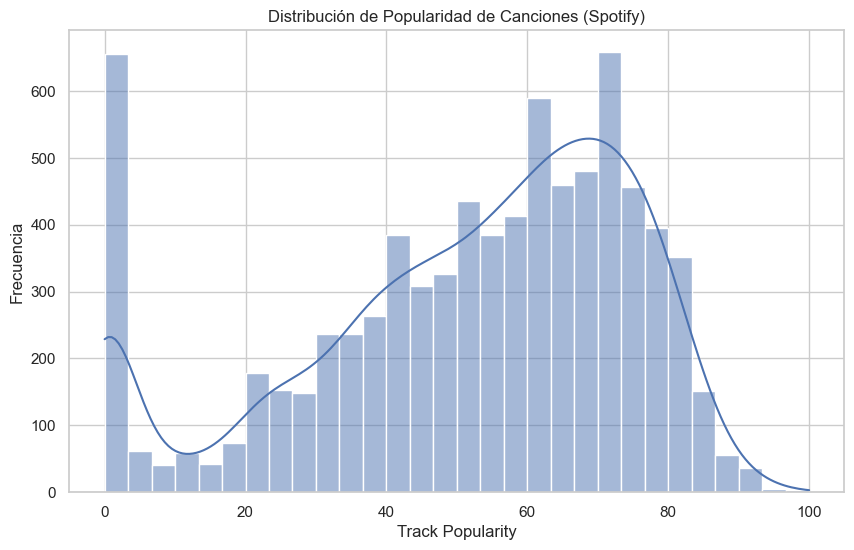

In [69]:
# Distribución de popularidad de tracks
plt.figure(figsize=(10,6))
sns.histplot(df_spotify['track_popularity'], bins=30, kde=True)
plt.title('Distribución de Popularidad de Canciones (Spotify)')
plt.xlabel('Track Popularity')
plt.ylabel('Frecuencia')
plt.show()

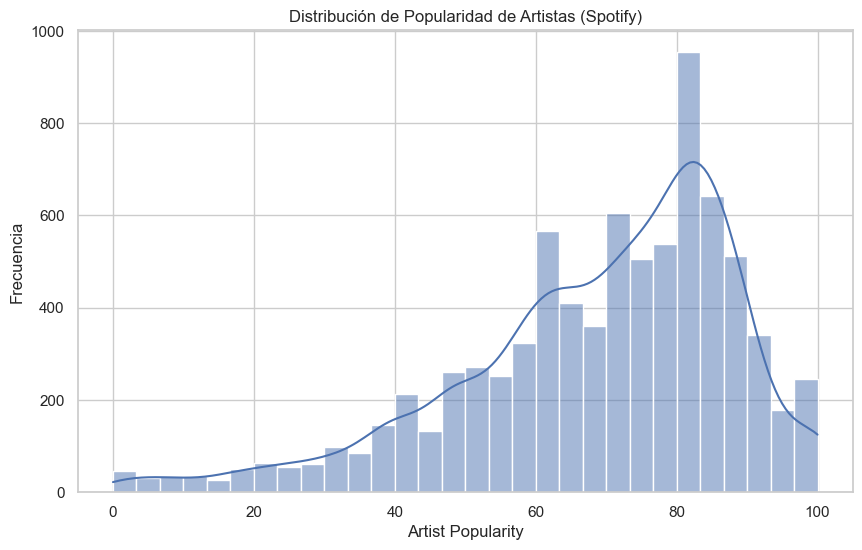

In [70]:
# Distribución de popularidad de artistas
plt.figure(figsize=(10,6))
sns.histplot(df_spotify['artist_popularity'], bins=30, kde=True)
plt.title('Distribución de Popularidad de Artistas (Spotify)')
plt.xlabel('Artist Popularity')
plt.ylabel('Frecuencia')
plt.show()

In [71]:
# Top 10 tracks y artistas
top10_tracks = df_spotify.sort_values(by='track_popularity', ascending=False).head(10)
top10_artists = df_spotify.drop_duplicates(subset='artist_name').sort_values(by='artist_popularity', ascending=False).head(10)

print("Top 10 Tracks (Spotify):")
display(top10_tracks[['track_name','artist_name','album_name','track_popularity']])
print("\nTop 10 Artists (Spotify):")
display(top10_artists[['artist_name','artist_popularity','artist_followers']])


Top 10 Tracks (Spotify):


,track_name,artist_name,album_name,track_popularity
15804,The Fate of Ophelia,Taylor Swift,The Life of a Showgirl,100
13066,Golden,HUNTR/X,KPop Demon Hunters (Soundtrack from the Netfli...,99
14195,Opalite,Taylor Swift,The Life of a Showgirl,97
12325,Man I Need,Olivia Dean,Man I Need,95
15157,Elizabeth Taylor,Taylor Swift,The Life of a Showgirl,95
10060,BIRDS OF A FEATHER,Billie Eilish,HIT ME HARD AND SOFT,94
17383,Father Figure,Taylor Swift,The Life of a Showgirl,94
11811,Soda Pop,Saja Boys,KPop Demon Hunters (Soundtrack from the Netfli...,94
14749,Wood,Taylor Swift,The Life of a Showgirl,93
10534,How It’s Done,HUNTR/X,KPop Demon Hunters (Soundtrack from the Netfli...,93



Top 10 Artists (Spotify):


,artist_name,artist_popularity,artist_followers
1496,Taylor Swift,100.0,145396321.0
8800,Drake,95.0,103039388.0
8697,Bad Bunny,95.0,102500980.0
5617,The Weeknd,94.0,112995439.0
8726,Justin Bieber,91.0,85008100.0
9088,Sabrina Carpenter,91.0,26516295.0
5546,Rihanna,90.0,68997177.0
8686,Ariana Grande,90.0,107374593.0
1705,Billie Eilish,90.0,118692183.0
9233,Kanye West,89.0,31038851.0


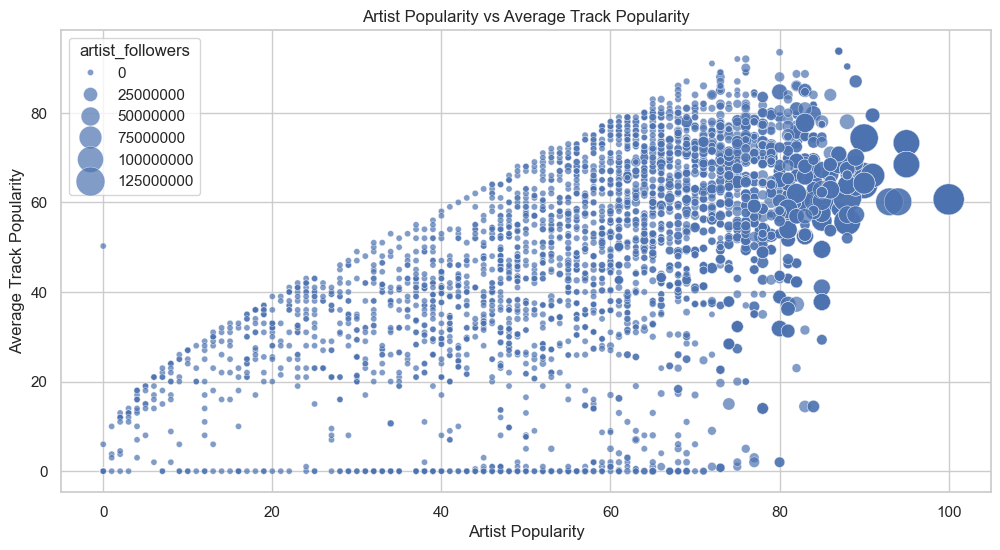

In [72]:
# Scatter: Artist Popularity vs Average Track Popularity
artist_avg_track_pop = df_spotify.groupby('artist_name')['track_popularity'].mean().reset_index().rename(columns={'track_popularity':'avg_track_popularity'})
artist_info = df_spotify[['artist_name','artist_popularity','artist_followers']].drop_duplicates()
artist_pop = artist_avg_track_pop.merge(artist_info, on='artist_name', how='left')

plt.figure(figsize=(12,6))
sns.scatterplot(data=artist_pop, x='artist_popularity', y='avg_track_popularity', size='artist_followers', alpha=0.7, sizes=(20,500))
plt.title('Artist Popularity vs Average Track Popularity')
plt.xlabel('Artist Popularity')
plt.ylabel('Average Track Popularity')
plt.grid(True)
plt.show()

### 4.2 Géneros más frecuentes

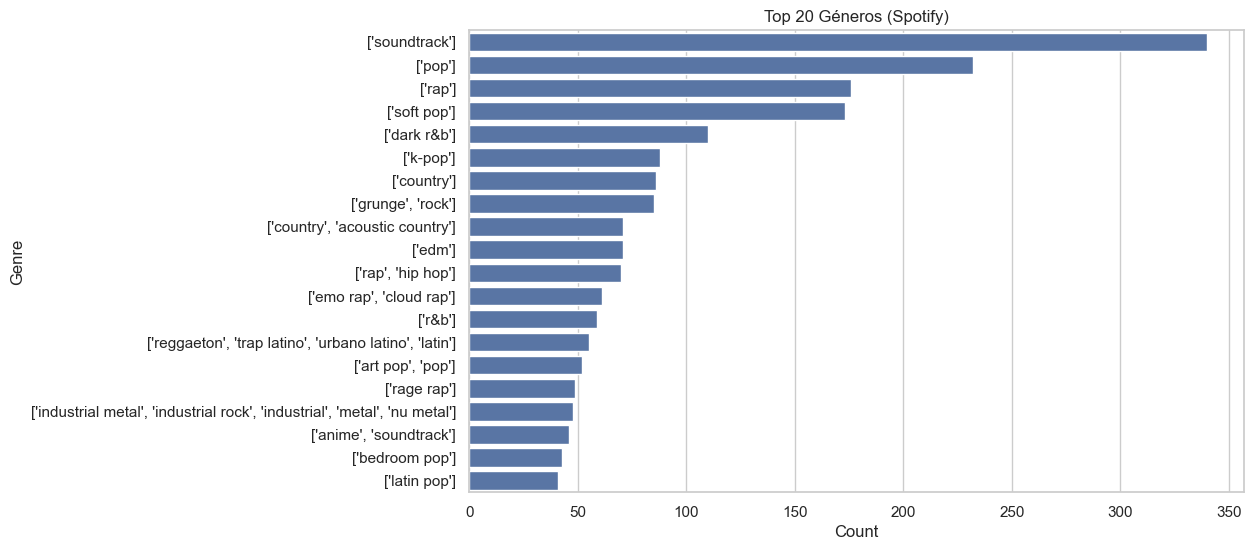

In [73]:
all_genres = df_spotify['artist_genres'].explode().dropna()
all_genres = all_genres[all_genres != '[]']
top_genres = Counter(all_genres).most_common(20)

plt.figure(figsize=(10,6))
sns.barplot(x=[g[1] for g in top_genres], y=[g[0] for g in top_genres])
plt.title('Top 20 Géneros (Spotify)')
plt.xlabel('Count')
plt.ylabel('Genre')
plt.show()


### 4.3. Evolución temporal

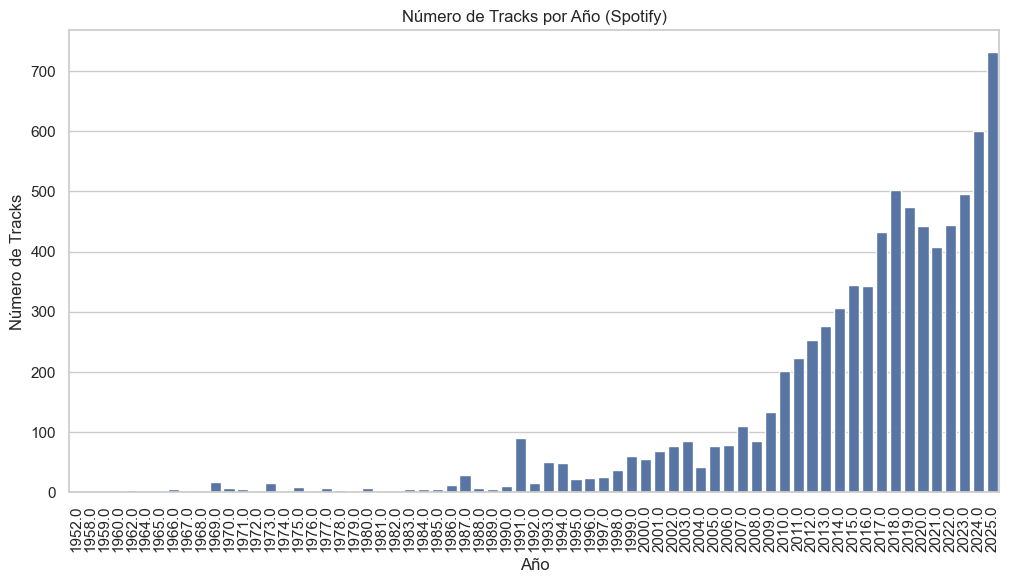

In [74]:
# Número de tracks por año
tracks_per_year = df_spotify.groupby('release_year')['track_id'].count().reset_index().rename(columns={'track_id':'num_tracks'})
plt.figure(figsize=(12,6))
sns.barplot(data=tracks_per_year, x='release_year', y='num_tracks')
plt.title('Número de Tracks por Año (Spotify)')
plt.xlabel('Año')
plt.ylabel('Número de Tracks')
plt.xticks(rotation=90)
plt.show()

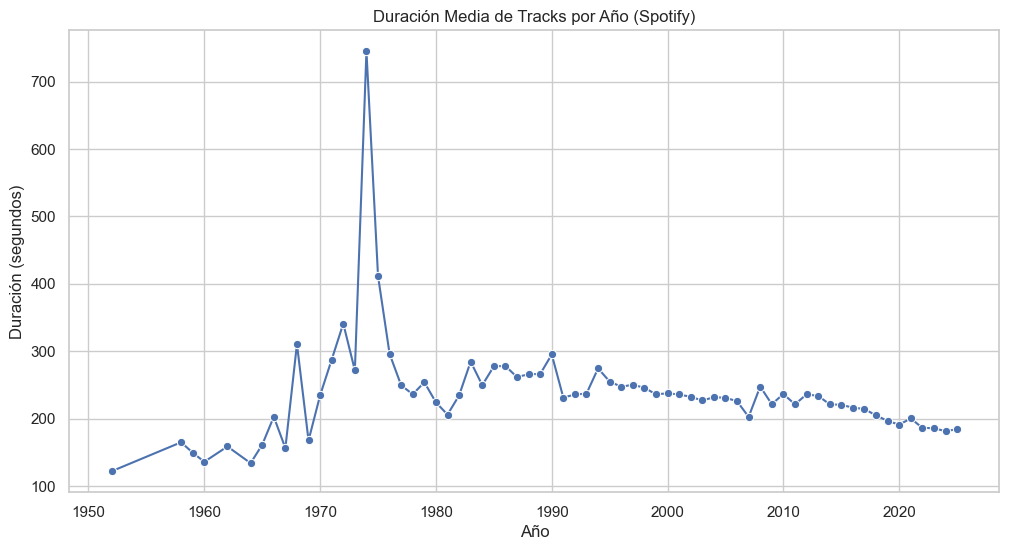

In [75]:
# Duración media de canción por año
avg_duration_per_year = df_spotify.groupby('release_year')['track_duration_sec'].mean().reset_index()
plt.figure(figsize=(12,6))
sns.lineplot(data=avg_duration_per_year, x='release_year', y='track_duration_sec', marker='o')
plt.title('Duración Media de Tracks por Año (Spotify)')
plt.xlabel('Año')
plt.ylabel('Duración (segundos)')
plt.grid(True)
plt.show()

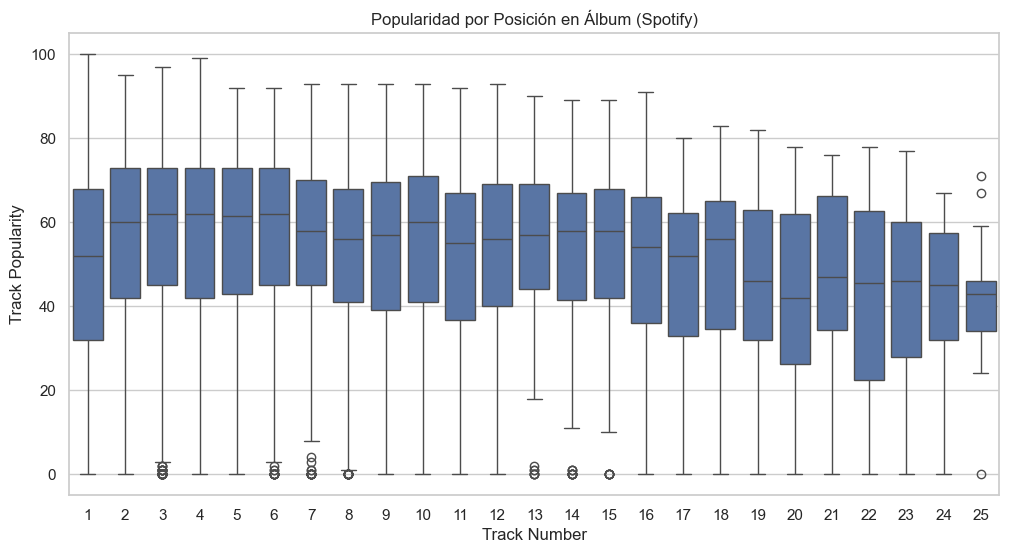

In [76]:
# Track popularity por posición en álbum
df_filtered = df_spotify[df_spotify['track_number'] <= 25]
plt.figure(figsize=(12,6))
sns.boxplot(data=df_filtered, x='track_number', y='track_popularity')
plt.title('Popularidad por Posición en Álbum (Spotify)')
plt.xlabel('Track Number')
plt.ylabel('Track Popularity')
plt.show()

### 4.4. Audio features exploration

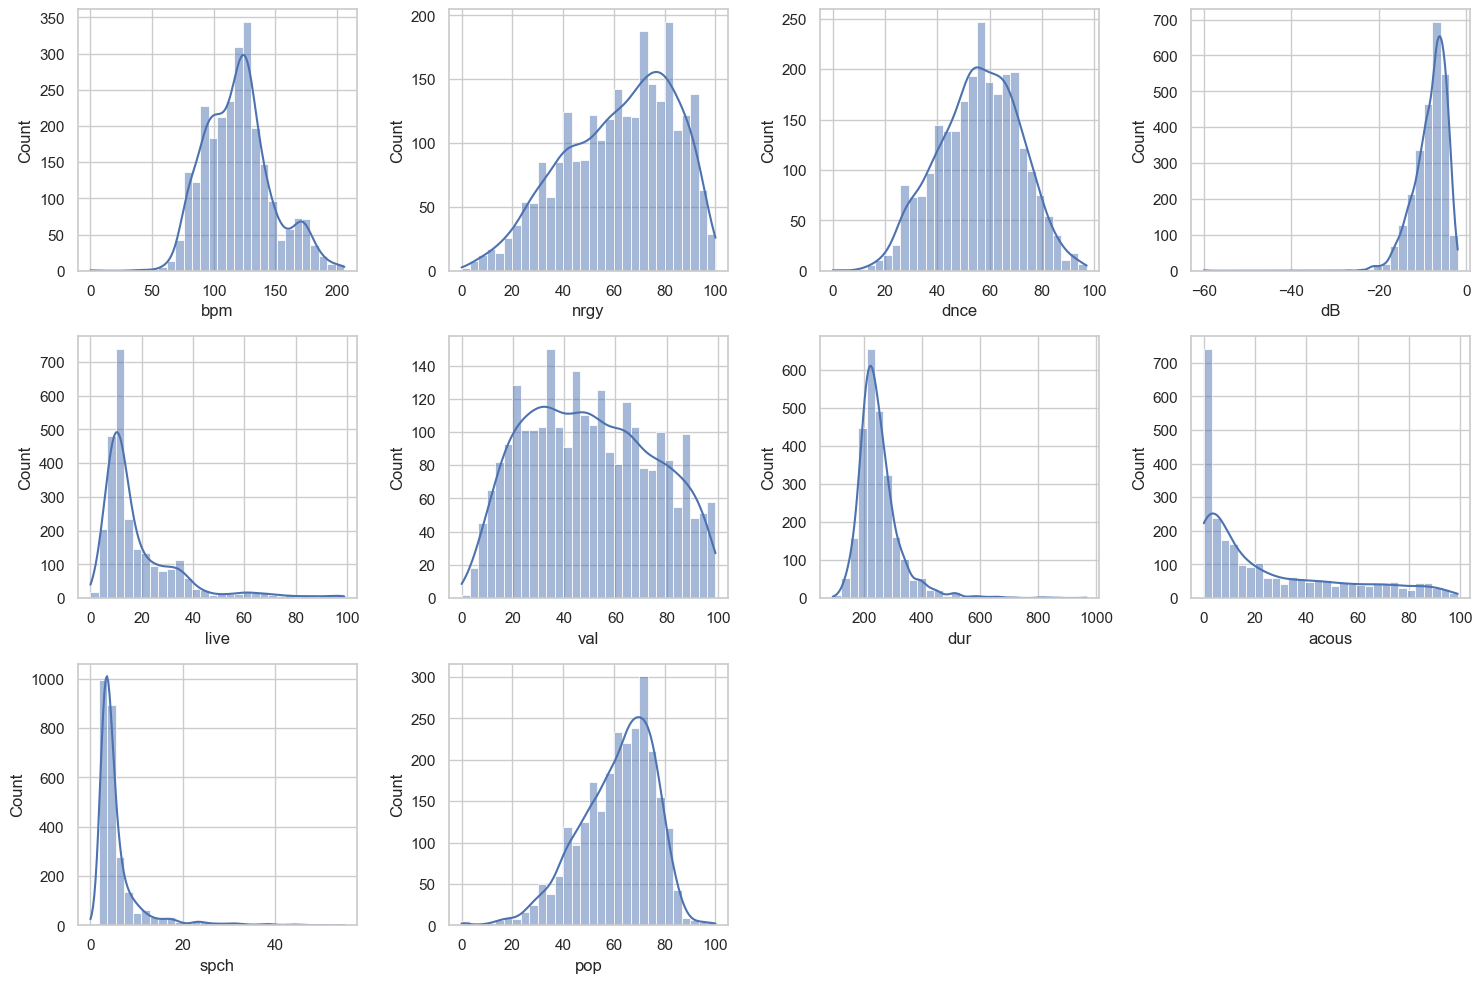

In [77]:
numeric_cols = ['bpm','nrgy','dnce','dB','live','val','dur','acous','spch','pop']
for col in numeric_cols:
    df_audiofeatures[col] = pd.to_numeric(df_audiofeatures[col], errors='coerce')

# Distribuciones
plt.figure(figsize=(15,10))
for i, col in enumerate(numeric_cols,1):
    plt.subplot(3,4,i)
    sns.histplot(df_audiofeatures[col], kde=True, bins=30)
plt.tight_layout()
plt.show()

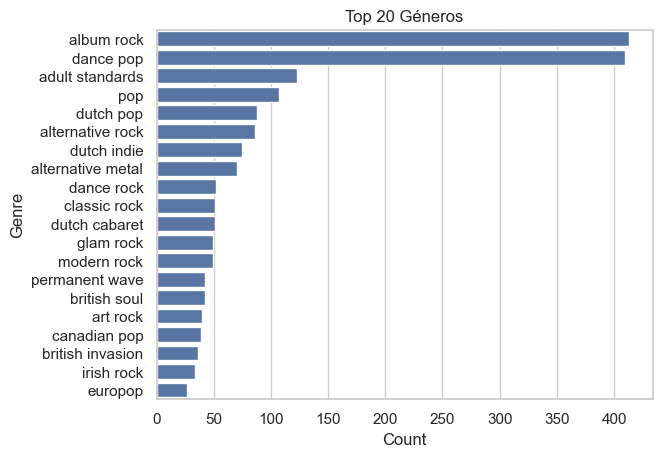

In [78]:
# Top géneros
top_genres_top = df_audiofeatures['top genre'].value_counts().head(20)
sns.barplot(x=top_genres_top.values, y=top_genres_top.index)
plt.title('Top 20 Géneros')
plt.xlabel('Count')
plt.ylabel('Genre')
plt.show()

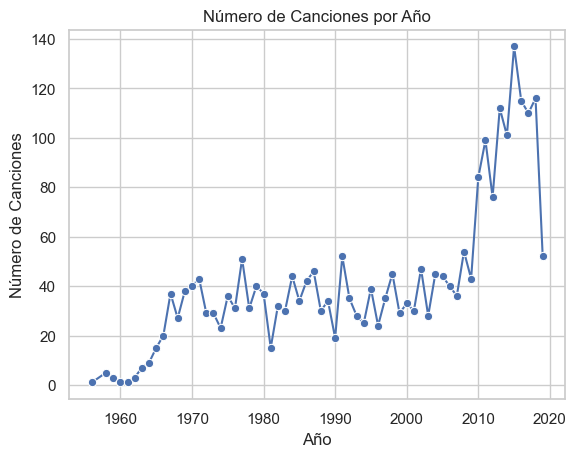

In [79]:
# Número de canciones por año
songs_per_year = df_audiofeatures['year'].value_counts().sort_index()
sns.lineplot(x=songs_per_year.index, y=songs_per_year.values, marker='o')
plt.title('Número de Canciones por Año')
plt.xlabel('Año')
plt.ylabel('Número de Canciones')
plt.show()

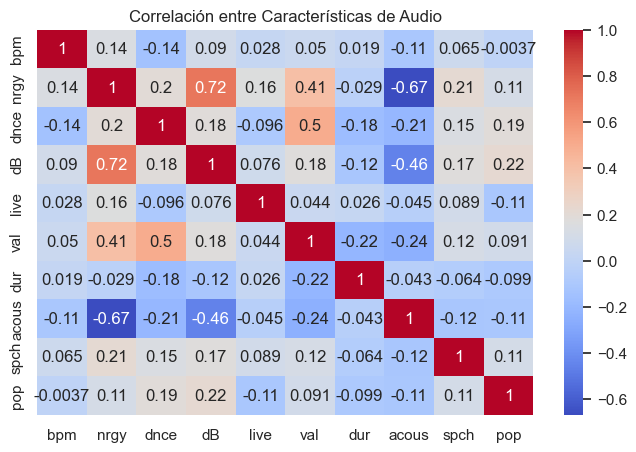

In [80]:
# Correlación entre features
plt.figure(figsize=(8,5))
sns.heatmap(df_audiofeatures[numeric_cols].corr(), annot=True, cmap='coolwarm')
plt.title('Correlación entre Características de Audio')
plt.show()

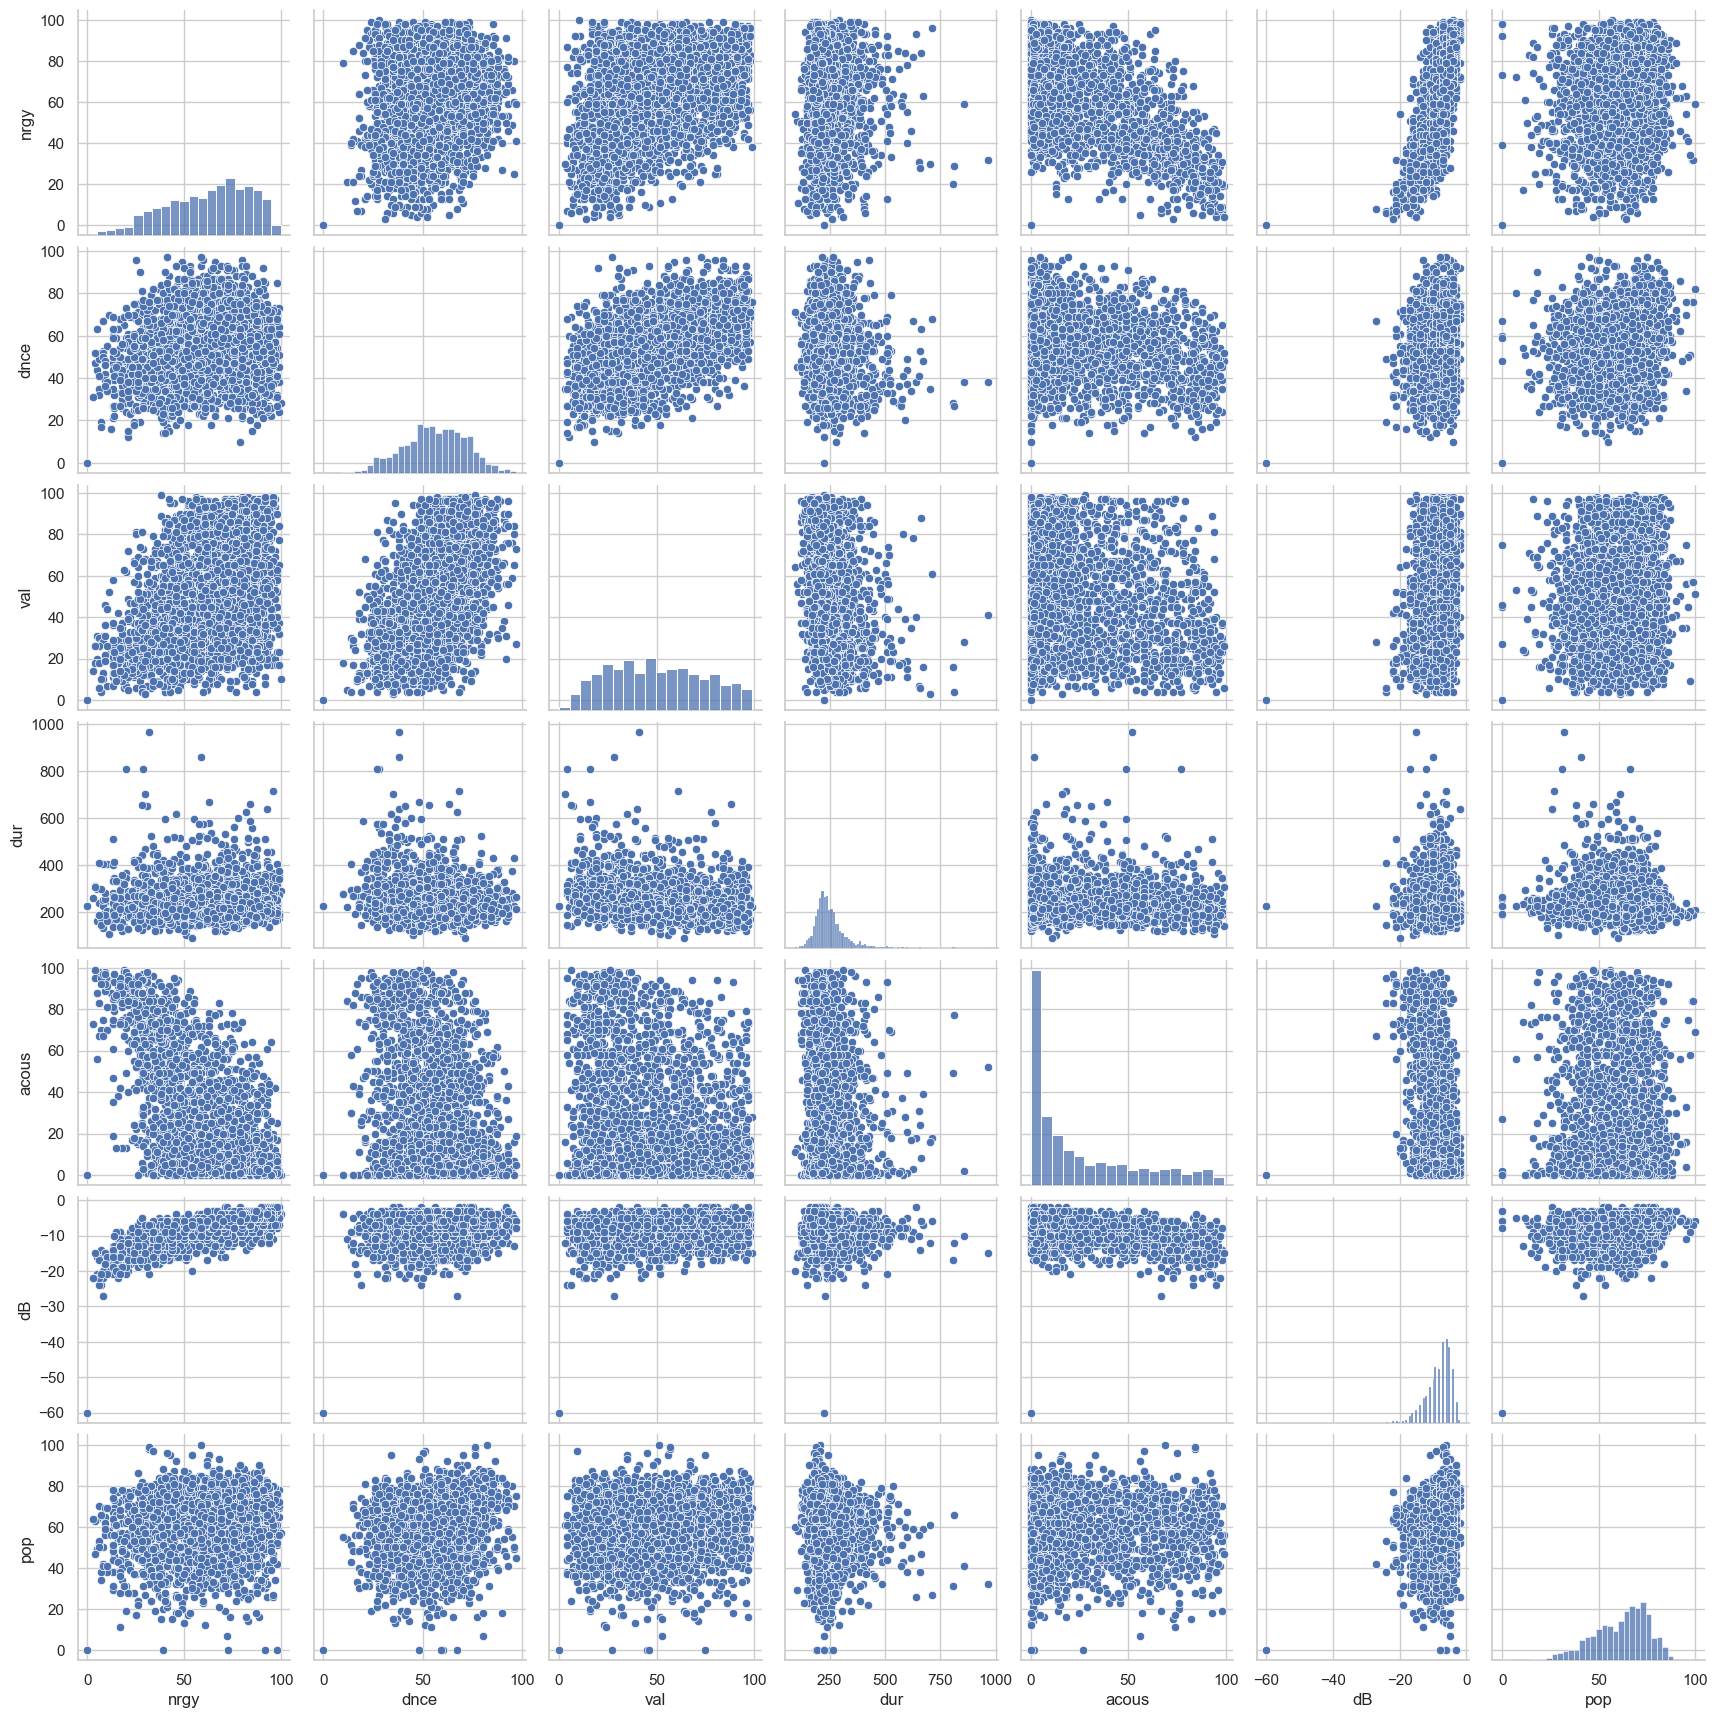

In [81]:
# Pairplot para relaciones principales
sns.pairplot(df_audiofeatures[['nrgy','dnce','val','dur','acous','dB','pop']])
plt.show()

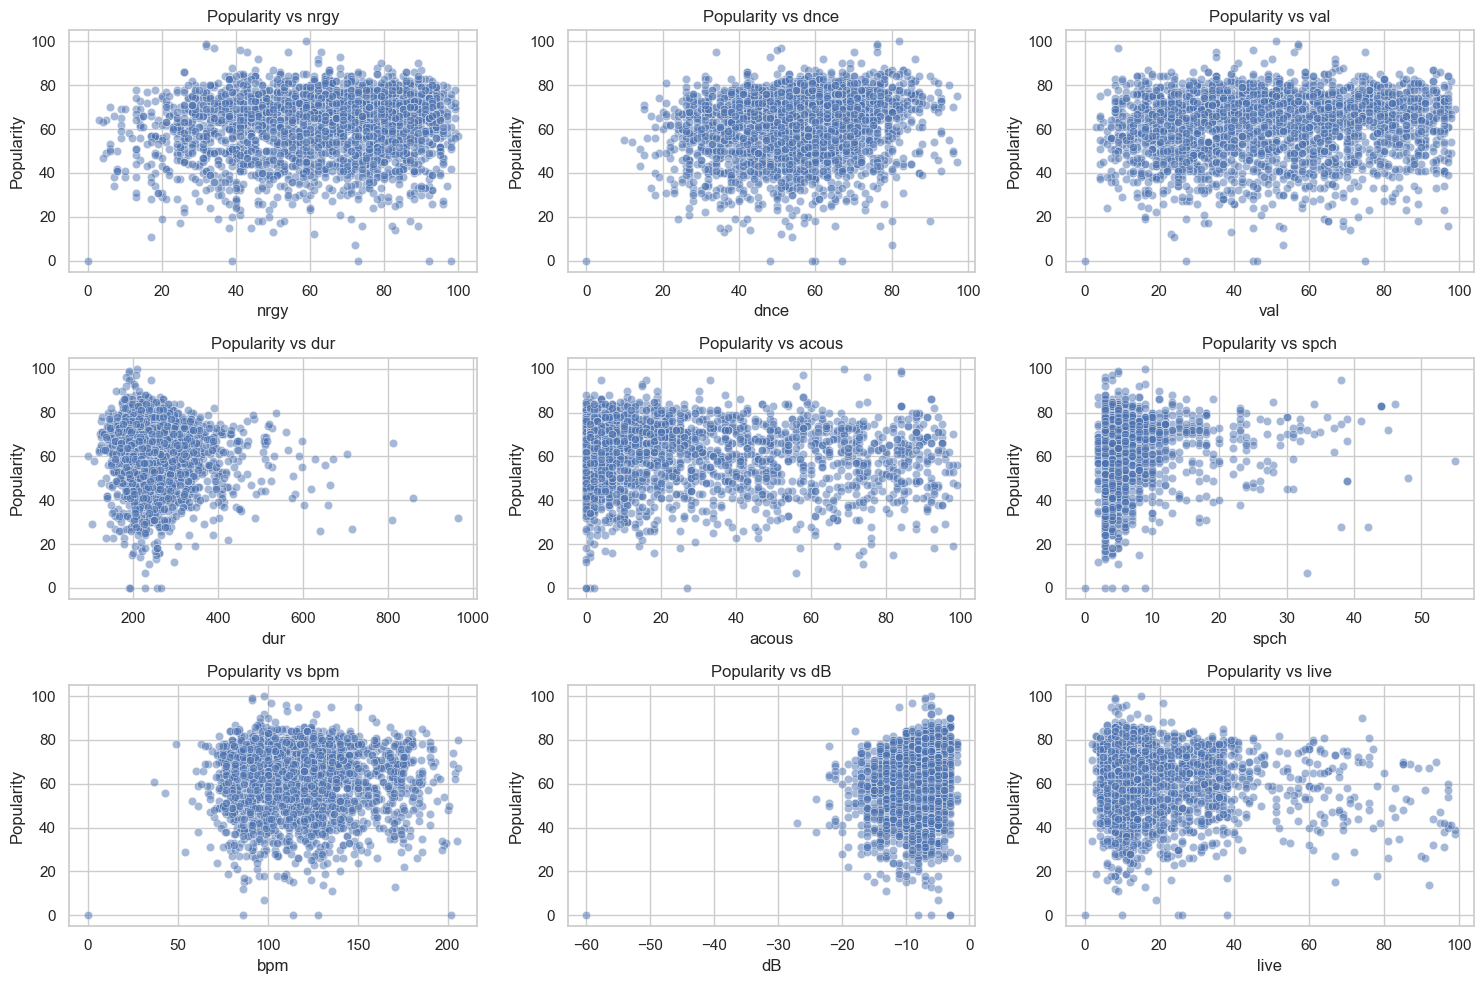

In [82]:
# Popularidad vs Features
plt.figure(figsize=(15,10))
features = ['nrgy','dnce','val','dur','acous','spch','bpm','dB','live']
for i, col in enumerate(features,1):
    plt.subplot(3,3,i)
    sns.scatterplot(data=df_audiofeatures, x=col, y='pop', alpha=0.5)
    plt.xlabel(col)
    plt.ylabel('Popularity')
    plt.title(f'Popularity vs {col}')
plt.tight_layout()
plt.show()

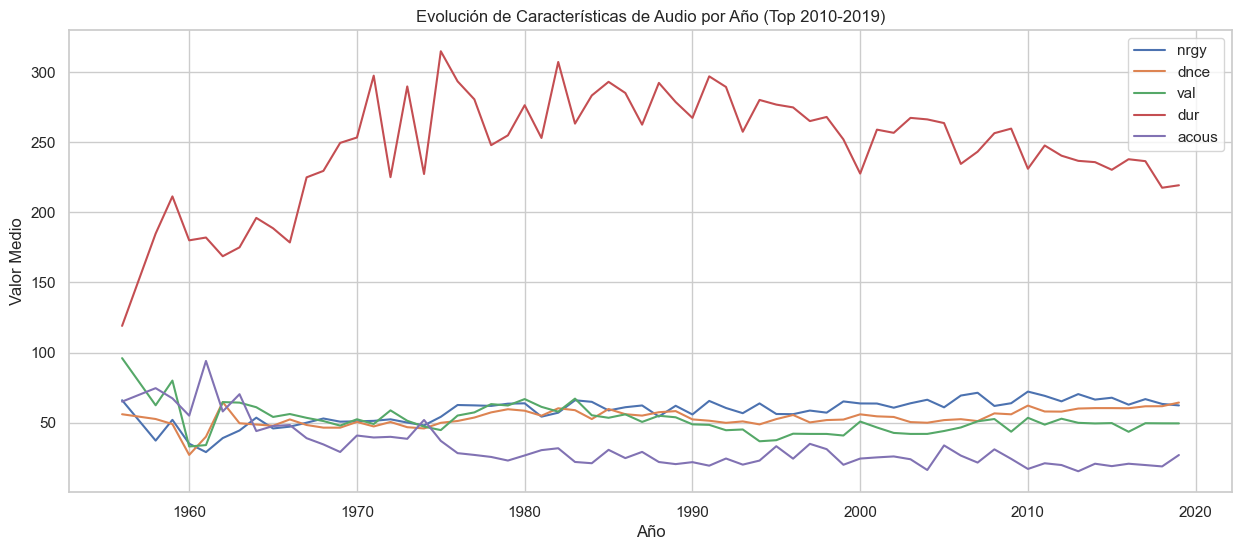

In [83]:
# Evolución media de features por año
avg_features_year = df_audiofeatures.groupby('year')[numeric_cols].mean().reset_index()
plt.figure(figsize=(15,6))
for col in ['nrgy','dnce','val','dur','acous']:
    sns.lineplot(data=avg_features_year, x='year', y=col, label=col)
plt.title('Evolución de Características de Audio por Año (Top 2010-2019)')
plt.xlabel('Año')
plt.ylabel('Valor Medio')
plt.legend()
plt.show()

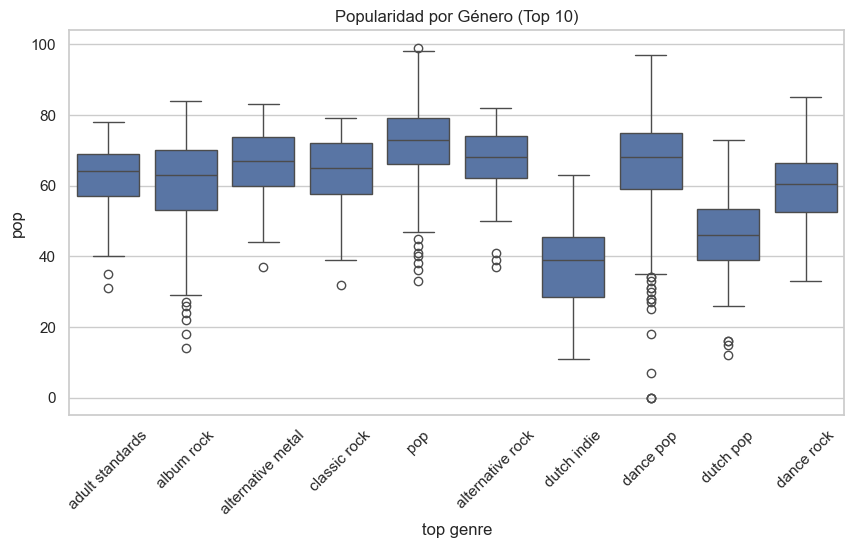

In [84]:
# Popularidad por género (top 10)
plt.figure(figsize=(10,5))
sns.boxplot(data=df_audiofeatures[df_audiofeatures['top genre'].isin(top_genres_top.index[:10])], x='top genre', y='pop')
plt.title('Popularidad por Género (Top 10)')
plt.xticks(rotation=45)
plt.show()

## **5. Machine Learning**

This section implements **Machine Learning** models for two main objectives:
1.  **Similar Song Recommender (KNN):** Uses a **K-Nearest Neighbors** model on standardized and one-hot encoded audio features to find songs similar to a given track or artist, serving as the core of the recommender system.
2.  **Popularity Prediction (Random Forest):** Trains a **Random Forest Regressor** to predict a song's **Popularity** score based on its audio features and genre.
3.  **Explainability (SHAP):** Uses **SHAP values** to interpret the Popularity Prediction model, revealing which audio features have the greatest positive or negative impact on a song's predicted popularity.
4.  **Genre Prediction (Logistic Regression):** Implements a **Logistic Regression** classifier to predict a song's simplified **Genre** based on its audio features, providing a basic classification task.

In [127]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import NearestNeighbors
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, f1_score
import joblib

In [86]:
# seleccionar columnas
numeric_cols = ['bpm','nrgy','dnce','dB','live','val','dur','acous','spch','pop']
categorical_cols = ['top genre']
id_cols = ['title', 'artist']

In [87]:
# asegurar que las columnas numéricas son del tipo correcto
for col in numeric_cols:
    df_audiofeatures[col] = pd.to_numeric(df_audiofeatures[col], errors='coerce')
df_audiofeatures = df_audiofeatures.dropna(subset=numeric_cols)

### 5.1. Similar Song Recommender

In [88]:
# preparar preprocesador
preprocess = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ]
)

In [89]:
# ajustar y transformar
X = preprocess.fit_transform(df_audiofeatures)

# guardar el preprocesador
joblib.dump(preprocess, 'models/recommender_preprocessor.pkl')

['models/recommender_preprocessor.pkl']

In [90]:
# entrenar el modelo de vecinos más cercanos (KNN)
knn = NearestNeighbors(n_neighbors=10, metric='euclidean')
knn.fit(X)

joblib.dump(knn, "models/recommender_knn.pkl")

['models/recommender_knn.pkl']

In [91]:
# recomendacion por canción
def recommend_songs(song_title, df=df_audiofeatures, model=knn, transformer=preprocess, n=10):

    # buscamos la canción exacta
    match = df[df['title'].str.lower() == song_title.lower()]

    if match.empty:
        return f"No encontré la canción '{song_title}'."

    # vector transformado
    song_vector = transformer.transform(match)

    # vecinos más cercanos
    distances, indices = model.kneighbors(song_vector, n_neighbors=n+1)

    results = df.loc[indices[0][1:]]  # excluimos la misma canción
    results["similarity"] = 1 / (1 + distances[0][1:])  # opcional: convertir distancia en similitud

    return results[[*id_cols, "similarity"]]

# ejemplo de uso
recommend_songs("Shape of You")

,title,artist,similarity
687,Shape of You,Ed Sheeran,1.000000
2292,The Heart Wants What It Wants,Selena Gomez,0.352280
2577,Only Human,Jonas Brothers,0.328586
2567,Lose You To Love Me,Selena Gomez,0.320944
2502,One Kiss (with Dua Lipa),Calvin Harris,0.319480
2446,Stay,Zedd,0.311076
1228,Human Nature,Michael Jackson,0.294921
565,Thinking out Loud,Ed Sheeran,0.294900
2258,Cannonball,Lea Michele,0.294900
1103,Still Believe,Herman Brood & His Wild Romance,0.294532


In [92]:
def recommend_songs_by_artist(artist_name, df=df_audiofeatures, model=knn, transformer=preprocess, n=10):

    # buscar canciones del artista
    artist_songs = df[df['artist'].str.lower() == artist_name.lower()]

    if artist_songs.empty:
        return f"No encontré canciones del artista '{artist_name}'."

    recommendations = []

    for _, song in artist_songs.iterrows():

        # convertir fila a DataFrame con 1 row
        song_df = song.to_frame().T  

        # vector transformado
        song_vector = transformer.transform(song_df)

        # vecinos
        distances, indices = model.kneighbors(song_vector, n_neighbors=n+1)

        # obtener canciones similares (excluimos la misma)
        recs = df.iloc[indices[0][1:]].copy()

        # añadir columna similitud
        recs["similarity"] = 1 / (1 + distances[0][1:])

        # guardar
        recommendations.append(recs[[*id_cols, "similarity"]])

    # concatenar todos los resultados
    recommendations = pd.concat(recommendations, ignore_index=True)

    # eliminar duplicados y ordenar
    recommendations = (
        recommendations
        .drop_duplicates(subset=id_cols)
        .sort_values("similarity", ascending=False)
        .head(n)
    )

    return recommendations

# ejemplo
recommend_songs_by_artist("Adele")

,title,artist,similarity
90,Hello,Adele,1.000000
40,Set Fire to the Rain,Adele,0.936256
91,When We Were Young,Adele,0.472702
31,All I Ask,Adele,0.468824
41,Rolling in the Deep,Adele,0.461354
42,Back To Black,Amy Winehouse,0.443487
201,Iron Sky,Paolo Nutini,0.410447
43,You Know I'm No Good,Amy Winehouse,0.405984
44,Rolling In The Deep,Adele,0.400088
45,Water Under the Bridge,Adele,0.398400


### 5.2. Popularity Prediction

In [93]:
numeric_cols.remove("pop")
target = "pop"

# categorical features to string
for col in categorical_cols:
    df_audiofeatures[col] = df_audiofeatures[col].astype(str)

# remove nans
df_audiofeatures = df_audiofeatures.dropna(subset=numeric_cols + categorical_cols + [target])

In [94]:
X = df_audiofeatures[numeric_cols + categorical_cols]
y = df_audiofeatures[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [95]:
# preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ],
    remainder='drop'
)

# pipeline
pipeline = Pipeline([
    ('pre', preprocessor),
    ('rf', RandomForestRegressor(n_estimators=200, max_depth=15, random_state=42, n_jobs=-1))
])

In [96]:
# train
pipeline.fit(X_train, y_train)

,steps,"[('pre', ...), ('rf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [97]:
# predict and evaluate
y_pred = pipeline.predict(X_test)
rmse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"RMSE: {rmse:.3f}, R2: {r2:.3f}")

RMSE: 165.297, R2: 0.231


In [98]:
joblib.dump(pipeline, "models/popularity_pipeline.pkl")

['models/popularity_pipeline.pkl']

### 5.3. Explainability

In [99]:
import shap

/Users/macbook/Documents/GitHub/SpotifyAnalytics2025/env_va/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [100]:
shap.initjs()
model = pipeline.named_steps["rf"]
preprocessor = pipeline.named_steps["pre"]

In [101]:
X_train_trans = preprocessor.transform(X_train)
X_test_trans  = preprocessor.transform(X_test)

In [102]:
num_names = numeric_cols
cat_names = preprocessor.named_transformers_["cat"].get_feature_names_out(categorical_cols)
feature_names = np.concatenate([num_names, cat_names])

In [103]:
X_train_shap = pd.DataFrame(X_train_trans.toarray() if hasattr(X_train_trans,"toarray") else X_train_trans,
                            columns=feature_names)
X_test_shap = pd.DataFrame(X_test_trans.toarray() if hasattr(X_test_trans,"toarray") else X_test_trans,
                           columns=feature_names)

In [106]:
explainer = shap.TreeExplainer(model)

In [107]:
shap_values = explainer(X_test_shap)
display(X_test_shap.head())
print(shap_values[0])

,bpm,nrgy,dnce,dB,live,val,dur,acous,spch,top genre_acid jazz,...,top genre_reggae,top genre_reggae fusion,top genre_rock-and-roll,top genre_scottish singer-songwriter,top genre_soft rock,top genre_stomp and holler,top genre_streektaal,top genre_trance,top genre_tropical house,top genre_yacht rock
0,-0.106970,0.585313,0.315375,-0.212864,1.269171,1.929023,1.971947,-0.882704,-0.514688,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.003479,0.818485,0.762418,0.573620,-0.352601,1.145556,-0.548594,-0.811037,-0.333609,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.769663,-1.606502,-0.834164,-0.999348,-0.414977,-1.905841,0.401774,1.697301,-0.514688,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.003479,0.212238,1.656504,1.097943,-0.789232,1.805318,-0.218031,0.156464,-0.152529,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.107969,0.911753,-0.067805,-0.212864,-0.913983,0.279619,-0.465953,-0.846871,-0.152529,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


.values =
array([-1.15209212e-02, -7.33147242e-03,  4.67536075e-01,  7.28099201e-02,
       -7.15941587e-01,  4.70101452e-01, -1.72176024e+00,  3.12793464e-01,
       -3.20084979e-01, -8.50736824e-07, -4.77767606e-05,  5.48952335e-02,
        2.61115393e-03,  6.54451612e-02,  2.04289831e-05,  4.00490225e-03,
       -9.72190504e-05, -5.16457489e-03,  8.07103647e-04,  8.52048325e-03,
       -7.96219449e-05, -1.56115776e-02,  1.08559180e-03,  1.91480852e-03,
        1.41798361e-02,  1.45560136e-02,  6.37193768e-03,  2.35167394e-04,
        1.59005963e-05, -7.59483896e-05, -3.26379407e-05,  2.40930525e-03,
       -6.65217302e-04,  2.98388747e-03,  1.11643413e-05,  3.63661940e-04,
       -1.21942609e-04,  3.37390149e-03, -1.06444274e-04,  1.73545148e-05,
        3.96773099e-04,  2.42934478e-03,  1.53108715e-02, -2.34516740e-03,
        1.25514489e-04,  8.07721467e-03, -3.57618462e-05, -5.70988197e-04,
        8.88845388e-05,  2.05997893e-02, -8.97575671e-05, -3.44522684e-03,
        0.00000

In [108]:
y_pred = pipeline.predict(X_test)
avg_popularity = y_pred.mean()

print(f"Average predicted popularity for the test songs: {avg_popularity:.2f}")

Average predicted popularity for the test songs: 61.31


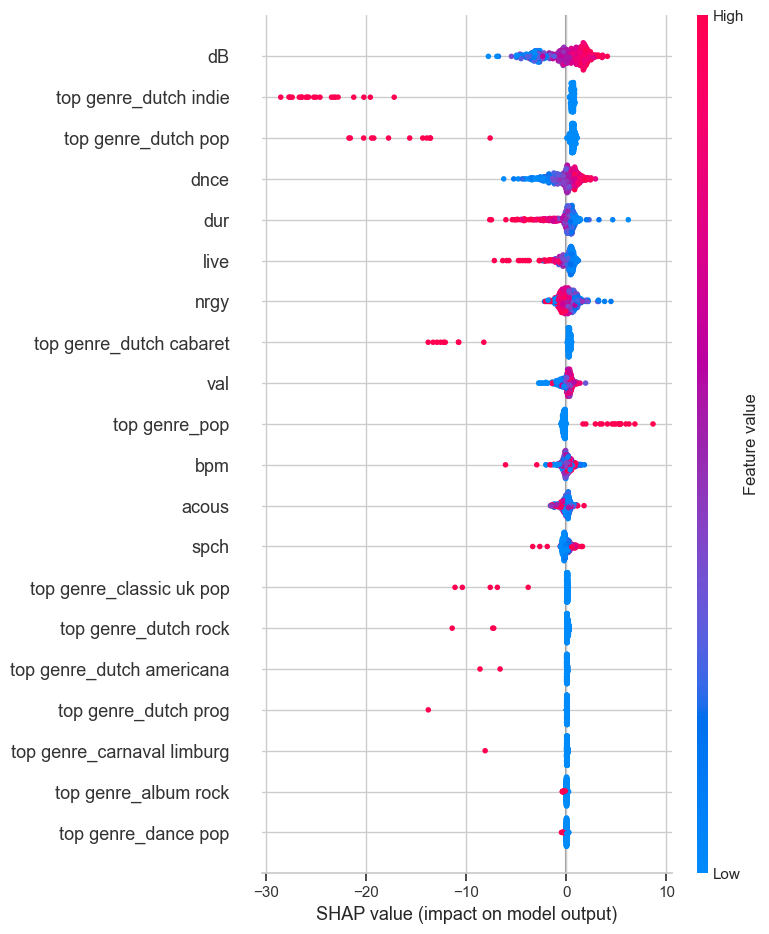

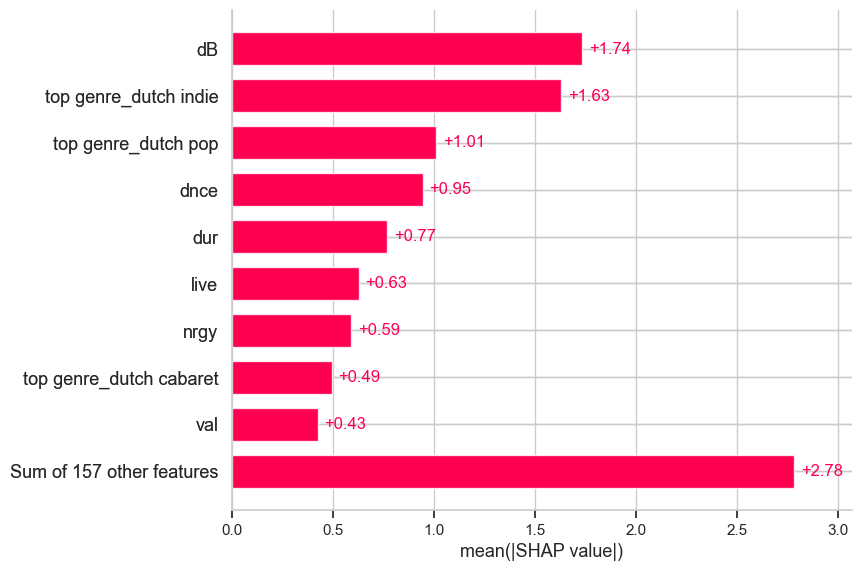

In [109]:
# Global explainability

# Beeswarm plot
shap.summary_plot(shap_values, X_test_shap)

# Bar plot of mean(|SHAP|)
shap.plots.bar(shap_values)

#### **Interpretation:** 

The SHAP summary plot provides a clear view of how each feature contributes to the model’s prediction of song popularity. Loudness (dB) is the most influential feature, where louder tracks tend to increase predicted popularity, while softer tracks decrease it. A large cluster of genre-related one-hot encoded variables also shows strong impact: certain genres consistently push predictions upward or downward, indicating that genre characteristics play a major role in determining popularity within the dataset.

Features such as danceability and duration display intuitive patterns: highly danceable songs tend to increase predicted popularity, whereas unusually long or short tracks reduce it. Mid-level influences come from energy, valence, and tempo (BPM), each contributing subtle but meaningful adjustments depending on their values. Meanwhile, high acousticness or speechiness generally reduces popularity, which aligns with the observation that highly acoustic or speech-heavy tracks are less likely to be mainstream hits.

Overall, the SHAP analysis confirms that the model captures musically meaningful relationships, blending genre information with audio characteristics to form a coherent and interpretable explanation of what drives popularity in the dataset.

### 5.4. Genre Prediction

This section builds a machine-learning classifier that predicts a song’s genre based on its audio features. It requires genre simplification first:

In [121]:
genre = df_audiofeatures["top genre"].str.strip().str.lower()
def genre_splitter(genre_series):
    out = genre_series.str.split(pat=" ", n=1)
    for i in range(len(out)):
        if len(out[i]) > 1:
            out[i] = [out[i][1]]
    return out.str.join("")

genre_m1 = genre.copy()

while genre_m1.str.contains(" ").any():
    genre_m1 = genre_m1.str.split().str[-1]

df_audiofeatures["genre_root"] = genre_m1
df_audiofeatures["genre_root"].value_counts()

genre_root
rock         853
pop          802
standards    123
metal         93
indie         78
            ... 
j-core         1
cyberpunk      1
motown         1
bebop          1
hollywood      1
Name: count, Length: 73, dtype: int64

In [122]:
# remove rare genres
vc = df_audiofeatures["genre_root"].value_counts()

# List of too-small classes
to_remove = vc[vc < 20].index.tolist()

df_m1 = df_audiofeatures[~df_audiofeatures["genre_root"].isin(to_remove)].copy()

df_m1["genre_root"].value_counts()

genre_root
rock         853
pop          802
standards    123
metal         93
indie         78
soul          56
cabaret       51
hop           43
wave          42
invasion      36
europop       27
mellow        26
dance         22
band          21
folk          20
Name: count, dtype: int64

In [123]:
feature_cols = ['bpm', 'dnce', 'live', 'val', 'dur', 'acous', 'spch', 
                'nrgy', 'dB']

X = df_m1[feature_cols]
y = df_m1['genre_root']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [ ]:
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# save scaler
joblib.dump(scaler, "models/genre_scaler.pkl")

In [ ]:
model = LogisticRegression(multi_class="ovr", max_iter=500, random_state=42)
model.fit(X_train_scaled, y_train)

pred_test = model.predict(X_test_scaled)

print("Test F1:", f1_score(y_test, pred_test, average="micro"))

# save model
joblib.dump(model, "models/genre_classifier.pkl")

Test F1: 0.5272331154684096


/Users/macbook/Documents/GitHub/SpotifyAnalytics2025/env_va/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1281: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


In [148]:
# function to predict a song's genre
def predict_genre(song_title, df=df_m1, model=model, scaler=scaler):
    song_data = df[df['title'].str.lower() == song_title.lower()]
    if song_data.empty:
        return f"No encontré la canción '{song_title}'."
    song_features = song_data[feature_cols]
    song_features_scaled = scaler.transform(song_features)
    genre_pred = model.predict(song_features_scaled)
    true_genre = song_data['genre_root'].values[0]
    return {
        'Predicted Genre': genre_pred[0],
        'True Genre': true_genre
    }

# ejemplo de uso
print(predict_genre("Shape of You"))
print(predict_genre("Waitin' On A Sunny Day"))

{'Predicted Genre': 'pop', 'True Genre': 'pop'}
{'Predicted Genre': 'rock', 'True Genre': 'rock'}
